#**Importation des bibliothèques**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import requests
import zipfile
import io

# Download necessary NLTK data (only need to run this once)
nltk.download('stopwords')

# Make graphs look nice
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Chargement des données**

In [13]:
from datasets import load_dataset

# Charger le dataset
dataset = load_dataset("dbarbedillo/SMS_Spam_Multilingual_Collection_Dataset")

# Get original column names
original_columns = dataset["train"].column_names

# Sélectionner uniquement les colonnes des textes en français et labels (ham/spam)
# Et supprimer toutes les autres colonnes d'origine
fr_data = dataset["train"].map(lambda x: {"text": x["text_fr"], "labels": x["labels"]}, remove_columns=original_columns)

# Retirer les entrées vides
fr_data = fr_data.filter(lambda x: x["text"] is not None and x["text"].strip() != "")

# Vérifier
print(len(fr_data))

# Afficher les 5 premiers exemples
for i in range(5):
    print(fr_data[i])
    print("-" * 50)

5572
{'labels': 'ham', 'text': "Allez jusqu'à Jurong point, fou.. Disponible seulement dans bugis n grand monde la e buffet... Cine il y a eu plus..."}
--------------------------------------------------
{'labels': 'ham', 'text': "J'ai fait une blague sur le wif u oni..."}
--------------------------------------------------
{'labels': 'spam', 'text': "Entrée libre dans 2 a wkly comp pour gagner FA Cup final tkts 21 mai 2005. Texte FA à 87121 pour recevoir la question d'entrée(std txt rate)T&C's appliquer 08452810075over18's"}
--------------------------------------------------
{'labels': 'ham', 'text': 'U dun dit si tôt hor... U c déjà dire alors...'}
--------------------------------------------------
{'labels': 'ham', 'text': "Non, je ne pense pas qu'il va à usf, il vit dans le coin."}
--------------------------------------------------


# **Analyse exploratoire des données (AED)**

labels
ham     4825
spam     747
Name: count, dtype: int64


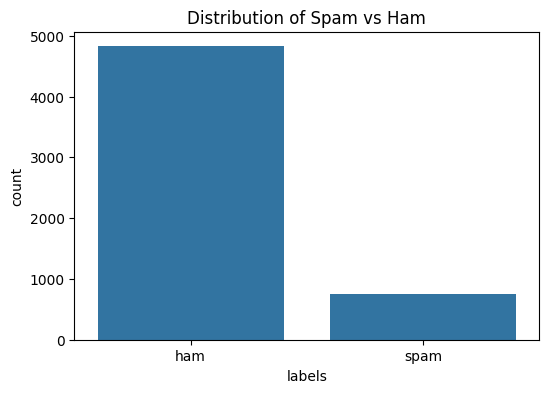

In [14]:
import pandas as pd

# Convertir le dataset en DataFrame pandas pour une manipulation plus facile
fr_data_df = fr_data.to_pandas()

print(fr_data_df['labels'].value_counts())

# Visualize it
plt.figure(figsize=(6,4))
sns.countplot(x='labels', data=fr_data_df)
plt.title("Distribution of Spam vs Ham")
plt.show()

# **Ingénierie des caractéristiques :**

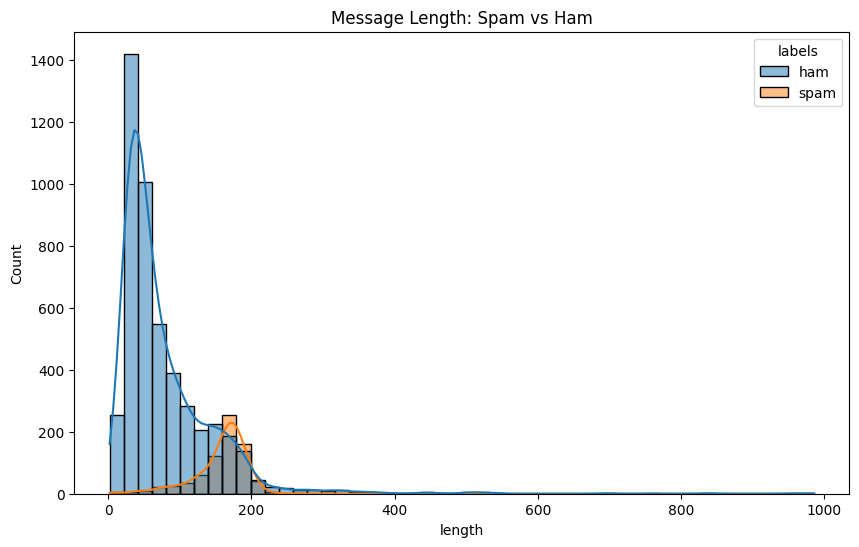

In [15]:
# Create a new column 'length'
fr_data_df['length'] = fr_data_df['text'].apply(len)

# Plot the distribution
plt.figure(figsize=(10,6))
sns.histplot(data=fr_data_df, x='length', hue='labels', bins=50, kde=True)
plt.title("Message Length: Spam vs Ham")
plt.show()